# Music Recommender System via Spotify API
Inspired by movie recommender systems we build on homework, we decided to create music recommender system using real user data from Spotify. We also compare method used in the course with 2 more advanced Collaborative Filtering method often used in business, to see which one is more appopriate.

### Environment requirement

* Standard Library: 
    * [io](https://docs.python.org/2/library/io.html)
    * [time](https://docs.python.org/2/library/time.html)
    * [json](https://docs.python.org/2/library/json.html)
    * [csv](https://docs.python.org/3/library/csv.html)

* Third Party
    * [pandas](https://pandas.pydata.org/pandas-docs/stable/install.html)
    * [requests](http://docs.python-requests.org/en/master/)
    * [spotipy](https://pypi.org/project/spotipy/): pip3 install spotipy
    * [fastai](https://docs.fast.ai/install.html): pip3 install fastai

In [ ]:
import spotipy
import spotipy.oauth2 as oauth2
import io, time, json
import requests
from pathlib import Path
import csv
import pandas as pd
import torch
from collections import Counter
from fastai.collab import *

# 1. Data scraper via Spotify API
Spotify provide us an [endpoint](https://developer.spotify.com/documentation/web-api/reference/playlists/get-list-users-playlists/) where we can get a list of user's playlists given the user_id. Our intuition is, all the tracks from the user's playlists should be ones that user enjoys the most. In order to assign a score to each track indicatng how much the user like that song, we considered user's total number of brodcast times, whether the user put this song to his 'fav' playlist etc. However, Spotify hide these information from us in order to protect user privacy. So at last we count the number of times a track occured in the user's playlists as an indicator of how much the user like that song. 
### Here are two helper functions that 
1. read client id and client secret given file path.
2. generate API token given client id and client secret.

In [98]:
def read_client_info(filepath):
    """
    Read the Spotify Client ID from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        client_id (string): The client_id
    """
    return Path(filepath).read_text().strip()

def generate_token():
    """ Generate the token from client_id and client_secret """
    credentials = oauth2.SpotifyClientCredentials(
        client_id=read_client_info("client_id.txt"),
        client_secret=read_client_info("client_secret.txt"))
    token = credentials.get_access_token()
    return token


### Helper functions for data scraping
To build a real music recommender system, we need a list of users, with each user a list of favorite songs and a score indicating how much the user like each song. So we need a few helper functions that:
1. Given playlist id/uri, return all the tracks in this playlist.
2. Given user id, return all the public playlists this user created or collected. 

In [119]:
def get_response(token, uri):
    headers = {'Authorization': 'Bearer %s' % token}
    rsp = requests.get(uri, headers=headers)
    return rsp.status_code, rsp.text

def get_tracks_from_playlist(token, playlist_uri):
    """
    Make an authenticated request to the Spotify API to get all the tracks in a public playlist.
    """
#     import pdb
    res = []
    status_code, txt = get_response(token, playlist_uri)
#     pdb.set_trace()
    if status_code == 200:
        d = json.loads(txt)
        tracks = d['tracks']
        while True:
            for item in tracks['items']:
                if item['track']:
                    track_name = item['track']['name']
                    res.append(track_name)
            if tracks['next']:
                tracks = spotify.next(tracks)
            else:
                break
    return res

def get_users_public_playlist(token, user_id):
    """
    Make an authenticated request to the Spotify API to get user's public playlists.
    """
    res = []
    nxt = "https://api.spotify.com/v1/users/" + user_id + "/playlists/?limit=50&offset=0"
    while nxt:
        status, txt = get_response(token, nxt)
        if status == 200:
            d = json.loads(txt)
            nxt = d['next']
            items = d['items']
            for item in items:
                tmp_d = {}
                tmp_d['playlist_id'] = item['id']
                tmp_d['playlist_name'] = item['name']
                track_names = get_tracks_from_playlist(token,item['href'])
                tmp_d['track_names'] = track_names
                res.append(tmp_d)
        else:
            return status, res
    return status, res

def transform_format(_id, playlists):
    tracks = []
    for d in playlists:
        tracks += d['track_names']
    c = Counter(tracks)
    return [_id] * len(c.keys()), list(c.keys()), list(c.values())

- Now we can start scraping data! We found that a large amount of user ids start with "11100563xxx". So we use this pattern to get a list of user data.  
- For each user id, if the request return status code "200" and the user has at list one playlist, we get all the tracks and calculate frequency for each track.  
- At last, we are able to get data from 266 users and 173559 songs in total

In [120]:
token = generate_token()
spotify = spotipy.Spotify(auth=token)

# example playlist
ids = []
tracknames = []
freqs = []
start = "11100563"
count = 0

for i in range(10):
    for j in range(10):
        for k in range(10):
            user_id = start + str(i) + str(j) + str(k)
            status, playlists = get_users_public_playlist(token, user_id)
            if playlists:
                print(count)
                tmp_ids, tmp_tracks, tmp_freqs = transform_format(count, playlists)
                ids += tmp_ids
                tracknames += tmp_tracks
                freqs += tmp_freqs
                assert len(ids) == len(tracknames)
                count += 1
            time.sleep(0.2)
df = pd.DataFrame({
    "user_id": ids,
    "trackname": tracknames,
    "freq": freqs
})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266


- Store df to csv

In [123]:
df.to_csv('spotify_266users.csv', index=False)

In [ ]:
user_ids = []
track_names = []
with open('small.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        user_ids.append(row[0])
        track_names.append(row[2])
user_ids = user_ids[1:]
track_names = track_names[1:]

In [ ]:
# df = pd.read_csv("spotify_dataset.csv",error_bad_lines=False)
# df = df[['user_id','trackname']]

# df['gid'] = (df.groupby('user_id').cumcount() == 0).astype(int)
# df['gid'] = df['gid'].cumsum()
# df['user_id'] = df['gid']
# df = df[['user_id','trackname']]
# df.to_csv("l.csv",index=False)

# users_unique = set(user_ids)
# tracks_unique = set(track_names)
# print(f"total data entries: {len(user_ids)}")
# print(f"number of unique users: {len(users_unique)}")
# print(f"number of unique tracks: {len(tracks_unique)}")

In [34]:
df = pd.read_csv('m.csv')
unique_tracks = set(df['trackname'])
track_to_index = {track: i for i, track in enumerate(unique_tracks)}
index_to_track = {i: track for i, track in enumerate(unique_tracks)}
df.trackname = df.trackname.apply(lambda x: track_to_index[x])

In [35]:
df['freq'] = df.groupby(['trackname','user_id'])['trackname'].transform("count")
df.drop_duplicates(inplace=True)

In [54]:
data = CollabDataBunch.from_df(df, valid_pct=0)
data.show_batch()

user_id,trackname,target
127,37193,1.0
97,16342,1.0
137,9872,1.0
111,53872,1.0
50,18131,2.0


In [55]:
min_freq = df.freq.min()
max_freq = df.freq.max()
print(f'min freq: {min_freq}, max freq: {max_freq}')

min freq: 1, max freq: 11


In [96]:
df.head()

,user_id,trackname,freq
0,1,50754,1
1,1,50817,1
2,1,42045,1
3,1,31899,1
4,1,12637,1


#### n_factors argument: the size of the embedding vectors

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


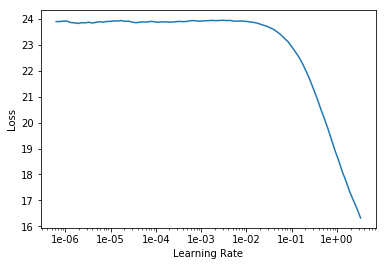

In [40]:
learn = collab_learner(data, n_factors=40, y_range=(min_freq, max_freq), wd=1e-3)
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [42]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.739728,0.541915,00:43
1,0.441935,0.488942,00:50
2,0.373596,0.473014,00:49
3,0.290773,0.465578,00:48
4,0.275574,0.466819,00:44


In [20]:
(users, items), freqs = next(iter(data.train_dl))
preds = learn.model(users, items)
print('User\tTrack\tReal\tPred\tDifference')
for p in list(zip(users, items, freqs, preds))[:16]:
    print('{}\t{}\t{}\t{:.1f}\t{:1f}'.format(p[0],p[1], p[2], p[3] ,p[3] - p[2]))

User	Track	Real	Pred	Difference
6	5704	1.0	1.0	0.000000
6	4067	1.0	1.0	0.000000
6	2889	1.0	1.0	0.000000
6	1058	2.0	1.0	-1.000000
6	3120	1.0	1.0	0.000000
2	7164	1.0	1.0	0.000000
6	7567	1.0	1.0	0.000000
6	1684	1.0	1.0	0.000000
6	7740	1.0	1.0	0.000000
6	1419	1.0	1.0	0.000000
6	5093	2.0	1.0	-1.000000
6	1455	2.0	1.0	-1.000000
6	4256	1.0	1.0	0.000000
6	5570	1.0	1.0	0.000000
2	7718	1.0	1.0	0.000000
4	2239	1.0	1.0	0.000000


In [57]:
learn = collab_learner(data, use_nn=True, 
                       emb_szs={'user_id':40, "trackname":40}, 
                       layers=[128,128], y_range=(min_freq, max_freq))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


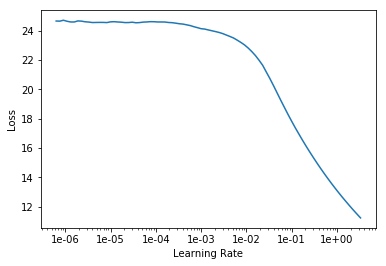

In [58]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [59]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.153080,#na#,00:36
1,0.140037,#na#,01:13
2,0.110207,#na#,01:14
3,0.077335,#na#,01:06
4,0.057052,#na#,00:56


In [62]:
(users, items), freqs = next(iter(data.train_dl))
preds = learn.model(users, items)
print('User\tTrack\tReal\tPred\tDifference')
for p in list(zip(users, items, freqs, preds))[:16]:
    print('{}\t{}\t{}\t{:.1f}\t{:1f}'.format(p[0],p[1], p[2], p[3][0] ,p[3][0] - p[2]))

tensor([ 11, 145, 147,  81, 127,  77,  11,  51, 149,  62,  53, 119, 149,  50,
         22, 108, 116,  33, 147,  81,  37,   6, 111,  54,  59,  40,  37,  37,
         54,  29, 107, 119,  54,  10,  47, 119,  31, 136,  11,  45,   2,  48,
        111,   2, 128,  66, 127,  78,  54,  54,  31,  11,   6,  31,   6,   6,
        136,  54, 129,  39, 125,  20,  10, 109])
User	Track	Real	Pred	Difference
11	23179	2.0	1.0	-0.998561
145	51547	1.0	1.0	0.002705
147	22027	2.0	1.7	-0.295967
81	57294	2.0	1.9	-0.053679
127	24053	3.0	2.2	-0.848913
77	64450	1.0	1.0	0.016667
11	7758	1.0	1.1	0.051311
51	31803	1.0	1.1	0.111274
149	42683	1.0	1.0	0.005009
62	13850	1.0	1.0	0.001558
53	65139	1.0	1.0	0.003084
119	21728	1.0	1.0	0.034046
149	13235	2.0	1.1	-0.901917
50	59159	1.0	1.0	0.026716
22	18147	1.0	1.0	0.005283
108	17401	1.0	1.0	0.002335


In [93]:
# num_tracks = len(unique_tracks)
num_tracks = learn.model.embeds[1].weight.shape[0]
user = torch.tensor([99] * num_tracks)
items = torch.tensor(range(num_tracks))
preds = learn.model(user, items)


In [94]:
index_to_track[preds.argmax().item()]

'Bd08'

In [95]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(151, 40)
    (1): Embedding(67014, 40)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=80, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)